In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

2024-11-30 16:44:14.479190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 16:44:14.507237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733003054.523808   69886 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733003054.528946   69886 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 16:44:14.546462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set paths
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1"
dataset_path = tf.keras.utils.get_file('ls_model_data_five.zip', origin=dataset_url, extract=True)
extracted_dir = os.path.splitext(dataset_path)[0]



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the dataset directory
dataset_dir = '/home/rrm3nh/.keras/datasets/ls_model_data_five_extracted'

# Define data generators with a validation split
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)

# Training generator
train_generator = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # Match model input size
    batch_size=32,
    class_mode='binary',    # Use 'binary' for two classes
    subset='training'       # Specify training data subset
)

# Validation generator
val_generator = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'     # Specify validation data subset
)

# Output dataset stats
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")


Found 5580 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.
Training samples: 5580
Validation samples: 1394


In [48]:
# Load DenseNet121 and build the model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use 2 units with softmax for multi-class
])

In [49]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Save the model
model.save('densenet_landslide_model.h5')

Epoch 1/10


I0000 00:00:1733004201.492665   70382 service.cc:148] XLA service 0x557698746260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733004201.492696   70382 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-11-30 17:03:21.799126: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/174 ━━━━━━━━━━━━━━━━━━━━ 51:42 18s/step - accuracy: 0.6250 - loss: 0.9843

I0000 00:00:1733004210.985238   70382 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 ━━━━━━━━━━━━━━━━━━━━ 132s 660ms/step - accuracy: 0.6344 - loss: 0.7123 - val_accuracy: 0.6352 - val_loss: 0.6540
Epoch 2/10
  1/174 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7188 - loss: 0.4505

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7188 - loss: 0.4505 - val_accuracy: 0.8889 - val_loss: 0.4389
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 98s 564ms/step - accuracy: 0.8405 - loss: 0.3628 - val_accuracy: 0.6032 - val_loss: 0.7145
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2987 - val_accuracy: 0.7222 - val_loss: 0.4987
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 99s 568ms/step - accuracy: 0.8861 - loss: 0.2834 - val_accuracy: 0.6163 - val_loss: 0.7522
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.2372 - val_accuracy: 0.8333 - val_loss: 0.5495
Epoch 7/10


2024-11-30 17:08:49.332225: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-30 17:08:49.332260: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13010600601101285561


154/174 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 0.8987 - loss: 0.2599 

In [64]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - accuracy: 0.5989 - loss: 0.8395
Validation Accuracy: 60.76%


In [65]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

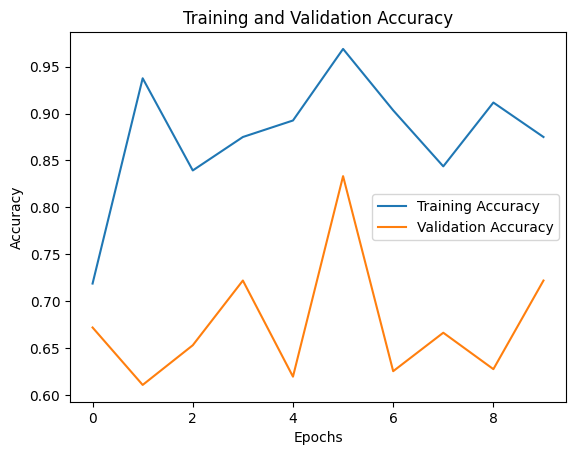

In [66]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


In [67]:
model_save_path = '/home/rrm3nh/.keras/models/densenet_landslide_model.h5'

# Save the model
model.save(model_save_path)
print(f"Model saved to {model_save_path}.")

Model saved to /home/rrm3nh/.keras/models/densenet_landslide_model.h5.


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

In [69]:
# Download and extract the test dataset
#test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"
#test_dataset_path = tf.keras.utils.get_file('test_google_images_landslide_three.zip', origin=test_dataset_url, extract=True)
#test_extracted_dir = os.path.splitext(test_dataset_path)[0]

# Check test dataset structure
#print(f"Test dataset extracted to: {test_extracted_dir}")

Test dataset extracted to: /home/rrm3nh/.keras/datasets/test_google_images_landslide_three_extracted


In [17]:
# Download and extract the test dataset
test_dataset_url = "https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1%27"
test_dataset_path = tf.keras.utils.get_file('test_google_images_landslides_four.zip', origin=test_dataset_url, extract=True)
test_extracted_dir = os.path.splitext(test_dataset_path)[0]

# Check test dataset structure
print(f"Test dataset extracted to: {test_extracted_dir}")

97215859/97215859 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Test dataset extracted to: /home/rrm3nh/.keras/datasets/test_google_images_landslides_four_extracted


In [18]:
import os
test_extracted_dir = '/home/rrm3nh/.keras/datasets/test_google_images_landslide_three_extracted'
print(os.listdir(test_extracted_dir))

['Google_Earth_Images']


In [19]:
test_dir = os.path.join(test_extracted_dir, 'Google_Earth_Images')

In [20]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # For binary classification, adjust if multi-class
    shuffle=False  # Ensure test data is not shuffled for evaluation
)

Found 114 images belonging to 2 classes.


In [21]:
# Load the saved model
model = tf.keras.models.load_model('densenet_landslide_model.h5')

In [74]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on the test set
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Threshold for binary classification

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4346 - loss: 1.3432 
Test Accuracy: 55.26%
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step 


In [75]:
print(f"Test Loss: {loss}")

Test Loss: 1.0095957517623901


In [76]:
# Display some results
for i, (img, label) in enumerate(zip(test_generator.filenames, predicted_classes)):
    print(f"Image: {img}, Predicted: {'Landslide' if label[0] == 1 else 'Non-Landslide'}")
    if i >= 9:  # Show the first 10 predictions
        break

Image: landslides/NASA_Arc_6038_vylg.jpg, Predicted: Non-Landslide
Image: landslides/NASA_Arc_8334_vylg.jpg, Predicted: Landslide
Image: landslides/NASA_GoogE_10521_large.jpg, Predicted: Non-Landslide
Image: landslides/NASA_GoogE_11540_cat.jpg, Predicted: Landslide
Image: landslides/NASA_GoogE_13710_cat.jpg, Predicted: Landslide
Image: landslides/NASA_GoogE_14445_cat.jpg, Predicted: Landslide
Image: landslides/nasa_g_1256m_10038_2018_large.jpg, Predicted: Landslide
Image: landslides/nasa_g_1950m_14143_2018_vylg.jpg, Predicted: Landslide
Image: landslides/nasa_g_2000m_10521_2017_large_two.jpg, Predicted: Non-Landslide
Image: landslides/nasa_g_2000m_14329_2011_large.jpg, Predicted: Landslide


In [77]:
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


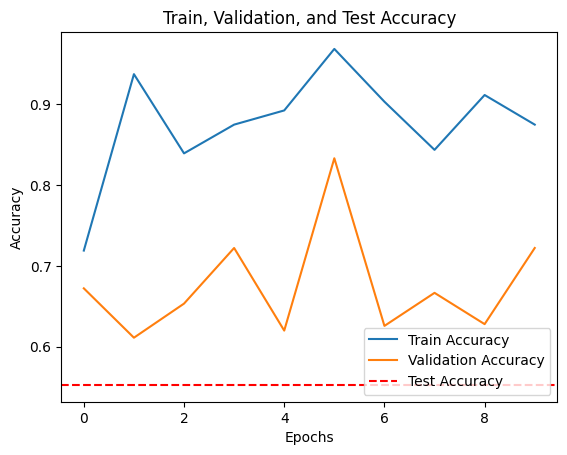

In [78]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Train, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## ADDING DATA AUGMENTATION

In [9]:
from tensorflow import keras


data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(factor=0.4),
    #layers.RandomSaturation(.7, seed=516) ## Error
    keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.3, upper=1.2))
  ]
)

In [10]:
# Load DenseNet121 and build the model

IMG_SIZE=224

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ### Adding Augmentation
inputs = data_augmentation(inputs)  ## Added Line

base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

model_2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use 2 units with softmax for multi-class
])

In [11]:
# Compile the model
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
    metrics=['accuracy']
)

# Model summary
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [12]:
# Train the model
history_2 = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Save the model
#model.save('densenet_landslide_model.h5')

/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_434']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1733003282.585509   70384 cuda_dnn.cc:529] Loaded cuDNN version 90300


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5722 - loss: 0.7961

/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/174 ━━━━━━━━━━━━━━━━━━━━ 117s 594ms/step - accuracy: 0.5726 - loss: 0.7955 - val_accuracy: 0.6003 - val_loss: 0.6487
Epoch 2/10
  1/174 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7812 - loss: 0.4562

2024-11-30 16:49:48.798079: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-30 16:49:48.798116: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7812 - loss: 0.4562 - val_accuracy: 0.6111 - val_loss: 0.6758
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 99s 567ms/step - accuracy: 0.7391 - loss: 0.5132 - val_accuracy: 0.6235 - val_loss: 0.6709
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.2375 - val_accuracy: 0.8333 - val_loss: 0.4842
Epoch 5/10


2024-11-30 16:51:28.626855: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 99s 567ms/step - accuracy: 0.8214 - loss: 0.3979 - val_accuracy: 0.6112 - val_loss: 0.7304
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2882 - val_accuracy: 0.5000 - val_loss: 0.9191


2024-11-30 16:53:07.561813: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 99s 567ms/step - accuracy: 0.8536 - loss: 0.3436 - val_accuracy: 0.6141 - val_loss: 0.7594
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.3253 - val_accuracy: 0.6111 - val_loss: 0.8113
Epoch 9/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 99s 567ms/step - accuracy: 0.8491 - loss: 0.3353 - val_accuracy: 0.6301 - val_loss: 0.7752
Epoch 10/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.8438 - loss: 0.2908 - val_accuracy: 0.5000 - val_loss: 0.9413


2024-11-30 16:56:25.446269: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [13]:
# Evaluate the model
loss, accuracy = model_2.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 349ms/step - accuracy: 0.6250 - loss: 0.7811
Validation Accuracy: 62.41%


In [14]:
train_accuracy = history_2.history['accuracy']
val_accuracy = history_2.history['val_accuracy']

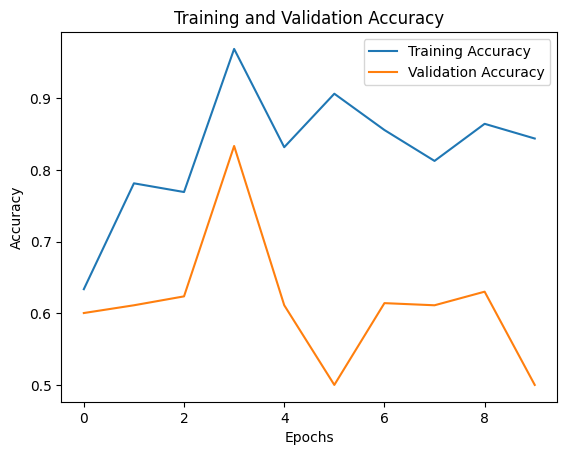

In [15]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

In [22]:
# Evaluate the model on the test set
loss, accuracy = model_2.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on the test set
predictions = model_2.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Threshold for binary classification

/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.5122 - loss: 1.1017
Test Accuracy: 51.75%


/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_434']. Received: the structure of inputs=*
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  


In [23]:
print(f"Test Loss: {loss}")

Test Loss: 0.9782480597496033


In [24]:
from sklearn.metrics import confusion_matrix
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[25 22]
 [32 35]]


### Adjusting hyperparameters to evaluate impact on performance
#### Have signs of overfitting in the previous versions

In [94]:
# Load DenseNet121 and build the model

IMG_SIZE=224

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ### Adding Augmentation
inputs = data_augmentation(inputs)  ## Added Line

base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

model_3 = models.Sequential([
    base_model,
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Use 2 units with softmax for multi-class
])

In [95]:
# Compile the model
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
    metrics=['accuracy']
)

# Model summary
model_3.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3, 3, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,217,409 (31.35 MB)

 Trainable params: 1,179,905 (4.50 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [96]:
# Train the model
history_3 = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Save the model
#model.save('densenet_landslide_model.h5')

Epoch 1/10


/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_4954']. Received: the structure of inputs=*
  warnings.warn(
E0000 00:00:1732998485.997199  999044 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_13_1/dropout_18_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


174/174 ━━━━━━━━━━━━━━━━━━━━ 111s 593ms/step - accuracy: 0.7765 - loss: 0.5248 - val_accuracy: 0.5974 - val_loss: 1.0476
Epoch 2/10
  1/174 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9062 - loss: 0.2321

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-30 15:29:50.177418: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.2321 - val_accuracy: 0.6667 - val_loss: 0.9128
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 99s 571ms/step - accuracy: 0.9353 - loss: 0.1674 - val_accuracy: 0.5959 - val_loss: 1.2089
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.0640 - val_accuracy: 0.6111 - val_loss: 0.6174
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 99s 571ms/step - accuracy: 0.9578 - loss: 0.1164 - val_accuracy: 0.5858 - val_loss: 1.2398
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0222 - val_accuracy: 0.7222 - val_loss: 0.9081
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 102s 584ms/step - accuracy: 0.9598 - loss: 0.1022 - val_accuracy: 0.6279 - val_loss: 1.1420
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 0.6667 - val_loss: 0.9327
Epoch 9/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 99s 570ms/step - accuracy: 0.9681 - loss: 0.0859 - val_accuracy: 

In [97]:
# Evaluate the model
loss, accuracy = model_3.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5871 - loss: 1.3651
Validation Accuracy: 58.61%


In [98]:
train_accuracy = history_3.history['accuracy']
val_accuracy = history_3.history['val_accuracy']

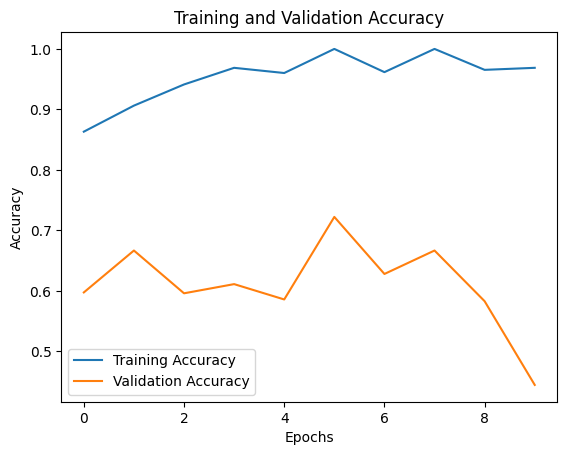

In [99]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

In [100]:
# Evaluate the model on the test set
loss, accuracy = model_3.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on the test set
predictions = model_3.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Threshold for binary classification

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.4075 - loss: 3.8179
Test Accuracy: 55.26%


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  


In [101]:
print(f"Test Loss: {loss}")

Test Loss: 2.696255922317505


In [102]:
from sklearn.metrics import confusion_matrix
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 9 38]
 [14 53]]


## Train/Validation on the 2nd model, 130 images from Google

In [25]:
import pathlib
import zipfile

data_dir_two = tf.keras.utils.get_file('test_google_images_landslides_four.zip', origin=test_dataset_url, extract=True)
data_dir_two = pathlib.Path(data_dir_two).with_suffix('')

In [26]:
print(data_dir_two)

/home/rrm3nh/.keras/datasets/test_google_images_landslides_four_extracted


In [27]:
## Update Directory
data_dir_two_alt_path = '/home/rrm3nh/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images'
print(data_dir_two_alt_path)

/home/rrm3nh/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images


In [28]:
## Set Batch and Image size. 
batch_size = 32
img_height = IMG_SIZE
img_width = IMG_SIZE

In [29]:
## Set Training Set image set. 
train_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.4,
  subset="training",
  seed=904,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 114 files belonging to 2 classes.
Using 69 files for training.


In [30]:
## Setup Valiation set.
valid_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.60,
  subset="validation",
  seed=904,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 114 files belonging to 2 classes.
Using 68 files for validation.


In [31]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in valid_dataset_two])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict_goog = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict_goog)

Class weights: {0: 1.1333333333333333, 1: 0.8947368421052632}


In [32]:
densnet_w_data_aug_hist = model_2.fit(train_dataset_two, epochs=20, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

Epoch 1/20


/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_434']. Received: the structure of inputs=*
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5577 - loss: 2.1943 - val_accuracy: 0.5294 - val_loss: 0.8638
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5494 - loss: 2.0009 - val_accuracy: 0.4853 - val_loss: 1.0861
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5008 - loss: 2.0249 - val_accuracy: 0.4706 - val_loss: 1.4853
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5081 - loss: 1.9994 - val_accuracy: 0.4559 - val_loss: 1.7952
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5365 - loss: 1.3384 - val_accuracy: 0.4412 - val_loss: 1.9164
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4847 - loss: 1.5540 - val_accuracy: 0.4412 - val_loss: 1.9060
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3882 - loss: 1.8465 - val_accuracy: 0.4412 - val_loss: 1.7108
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4668 - loss: 1.5950 - val_accuracy: 0.4559 - val_loss: 1.4638
Epoch 

In [33]:
train_accuracy = densnet_w_data_aug_hist.history['accuracy']
val_accuracy = densnet_w_data_aug_hist.history['val_accuracy']

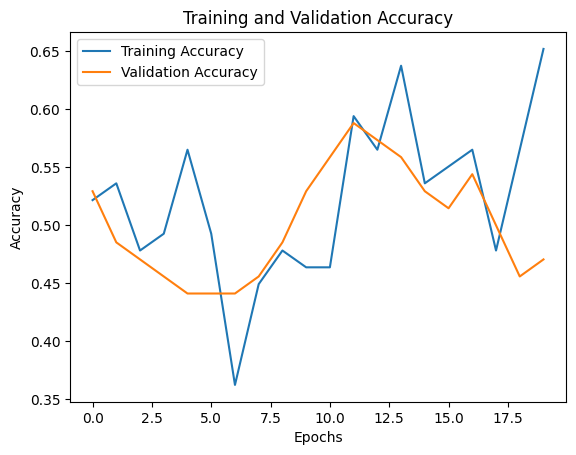

In [34]:

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

## Implementing Grad CAM

In [35]:
## Load Image
landslide_img_one_url = "https://dl.dropboxusercontent.com/scl/fi/viovy9pcma2y6hq58ntns/NASA_GoogE_14445.jpg?rlkey=ltitymrzuarrxxogge32c1kbi&dl=0?raw=1"
landslide_img_one_path = tf.keras.utils.get_file('NASA_GoogE_14445', origin=landslide_img_one_url)

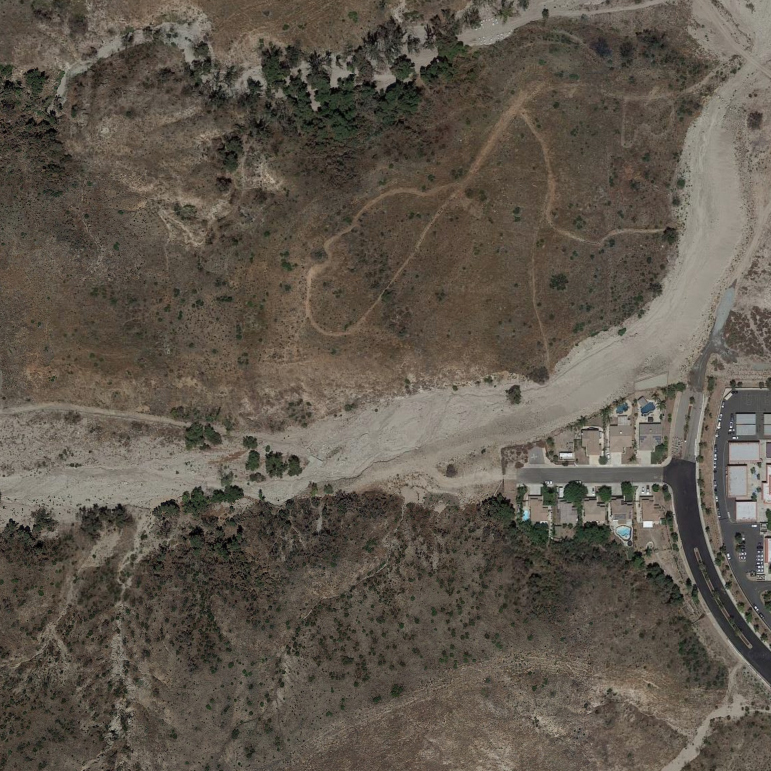

In [37]:
import PIL

PIL.Image.open(landslide_img_one_path)

In [38]:
from tensorflow.keras.models import clone_model
from IPython.display import Image, display
import matplotlib as mpl

In [39]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name,last_deep_layer_name,pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.get_layer(last_deep_layer_name).output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))



In [46]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

#model_2_clone = clone_model(model_2) #cloning so we can leave the original one intact
model_2.layers[-1].activation = None #turn activation off for the last prediction layer
last_conv_layer_name = "densenet121" #take the last convolutional layer
last_deep_layer_name = "dense_3"

In [47]:
img_size = (IMG_SIZE, IMG_SIZE)

img_array = preprocess_input(get_img_array(landslide_img_one_path, size=img_size))

preds = model_2.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model_2, last_conv_layer_name,last_deep_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/home/rrm3nh/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_870']. Received: the structure of inputs=*
  warnings.warn(


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m140333767321648\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[-0.3960784 , -0.41176468, -0.5058824 ],\n         [-0.30196077, -0.3333333 , -0.41960782],\n         [-0.31764704, -0.372549  , -0.45098037],\n         ...,\n         [ 0.14509809,  0.12941182,  0.03529418],\n         [ 0.15294123,  0.13725495,  0.04313731],\n         [ 0.1686275 ,  0.15294123,  0.05882359]],\n\n        [[-0.32549018, -0.35686272, -0.44313723],\n         [-0.29411763, -0.3490196 , -0.42745095],\n         [-0.31764704, -0.38823527, -0.4588235 ],\n         ...,\n         [ 0.20784318,  0.19215691,  0.09803927],\n         [ 0.20000005,  0.18431377,  0.09019613],\n         [ 0.19215691,  0.17647064,  0.082353  ]],\n\n        [[-0.34117645, -0.3960784 , -0.47450978],\n         [-0.34117645, -0.41176468, -0.4823529 ],\n         [-0.31764704, -0.3960784 , -0.46666664],\n         ...,\n         [ 0.19215691,  0.17647064,  0.082353  ],\n         [ 0.13725495,  0.12156868,  0.02745104],\n         [ 0.18431377,  0.1686275 ,  0.07450986]],\n\n        ...,\n\n        [[-0.5686275 , -0.5921569 , -0.64705884],\n         [-0.5529412 , -0.5764706 , -0.64705884],\n         [-0.4352941 , -0.5058824 , -0.5764706 ],\n         ...,\n         [-0.23137254, -0.3098039 , -0.38823527],\n         [-0.32549018, -0.40392154, -0.4823529 ],\n         [-0.21568626, -0.27843136, -0.36470586]],\n\n        [[-0.6313726 , -0.6313726 , -0.70980394],\n         [-0.46666664, -0.52156866, -0.6       ],\n         [-0.41176468, -0.46666664, -0.54509807],\n         ...,\n         [-0.23921567, -0.31764704, -0.3960784 ],\n         [-0.32549018, -0.40392154, -0.4823529 ],\n         [-0.38823527, -0.45098037, -0.5372549 ]],\n\n        [[-0.6627451 , -0.7176471 , -0.79607844],\n         [-0.35686272, -0.42745095, -0.4980392 ],\n         [-0.38039213, -0.4352941 , -0.5137255 ],\n         ...,\n         [-0.30196077, -0.36470586, -0.45098037],\n         [-0.30196077, -0.3490196 , -0.44313723],\n         [-0.23921567, -0.2862745 , -0.38039213]]]], dtype=float32)\n  • training=None\n  • mask=None'

In [ ]:
save_and_display_gradcam(landslide_img_one_path, heatmap)